In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [75]:
df = pd.read_csv('CryptoDatasetReddit.csv',index_col=0)

In [76]:
df.columns

Index(['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT',
       'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

In [77]:
df

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 19:00:00,8099.26,8109.92,8077.82,8086.65,1.910237,54.68,26.89869,174.40,22.319940,0.328284,0.142630,0.506278,0.110429,0.049857,0.839857,0.092543
2019-11-20 20:00:00,8083.19,8111.17,8081.72,8102.66,9.783435,55.06,21.18500,174.45,25.050680,0.000208,0.375000,0.500000,0.314500,0.000000,0.685500,0.511350
2019-11-20 21:00:00,8096.06,8111.25,8078.80,8098.29,1.726209,55.10,16.47622,175.48,32.281160,0.187590,-0.077778,0.144444,0.000000,0.157500,0.842500,-0.248400


# Dataset scalling

In [78]:
dataset = df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
Nfeatures = len(df.columns)
print('Number of features', Nfeatures)

Number of features 16


# Model Config

In [79]:
lookBack = 30*24
lstmLayers = 42
epochs=10
batchSize=128 

# Spliting datasets into train and test

In [80]:
trainSizePer = 0.70 
predictCol = df.columns.get_loc('close_BTCUSDT')

def create_dataset(dataset, predictCol, lookBack=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-lookBack-1):
    a = dataset[i:(i+lookBack), :]
    dataX.append(a)
    dataY.append(dataset[i + lookBack, predictCol])
  return np.array(dataX), np.array(dataY)


trainSize = int(len(dataset) * trainSizePer)
testSize = len(dataset) - trainSize
train, test = dataset[0:trainSize, :], dataset[trainSize:len(dataset), :]

trainX, trainY = create_dataset(train, predictCol, lookBack=lookBack)
testX, testY = create_dataset(test, predictCol, lookBack=lookBack)

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, Nfeatures))
testX = np.reshape(testX, (testX.shape[0],lookBack, Nfeatures))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look back ', lookBack)

Training dataset length  11575
Testing dataset length  4961
look back  720


# Building model and train

In [81]:
model = Sequential()
model.add(LSTM(lstmLayers, input_shape=(lookBack,Nfeatures)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [82]:
print('*' * 50)
print('Model summary:')
model.summary()

**************************************************
Model summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 42)                9912      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 43        
Total params: 9,955
Trainable params: 9,955
Non-trainable params: 0
_________________________________________________________________


In [83]:
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batchSize,shuffle=False)

Epoch 1/10
60/60 [==============================] - 31s 513ms/step - loss: 0.0145 - val_loss: 0.0021
Epoch 2/10
60/60 [==============================] - 30s 504ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/10
60/60 [==============================] - 30s 499ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/10
60/60 [==============================] - 30s 499ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/10
60/60 [==============================] - 31s 518ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/10
60/60 [==============================] - 30s 497ms/step - loss: 8.1123e-04 - val_loss: 9.9849e-04
Epoch 7/10
60/60 [==============================] - 30s 507ms/step - loss: 7.9388e-04 - val_loss: 8.9849e-04
Epoch 8/10
60/60 [==============================] - 30s 503ms/step - loss: 5.7962e-04 - val_loss: 8.4750e-04
Epoch 9/10
60/60 [==============================] - 30s 500ms/step - loss: 5.4591e-04 - val_loss: 7.5347e-04
Epoch 10/10
60/60 [==============================] - 30s 50

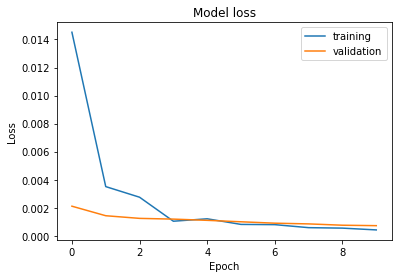

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [85]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_extended = np.zeros((len(trainPredict),Nfeatures))
trainPredict_extended[:,predictCol] = trainPredict[:,0]
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,predictCol]

testPredict_extended = np.zeros((len(testPredict),Nfeatures))
testPredict_extended[:,predictCol] = testPredict[:,0]
testPredict = scaler.inverse_transform(testPredict_extended)[:,predictCol] 

trainY_extended = np.zeros((len(trainY),Nfeatures))
trainY_extended[:,predictCol]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,predictCol]

testY_extended = np.zeros((len(testY),Nfeatures))
testY_extended[:,predictCol]=testY
testY = scaler.inverse_transform(testY_extended)[:,predictCol]

trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

Text(0.5, 1.0, 'Bitcoin Price Prediction')

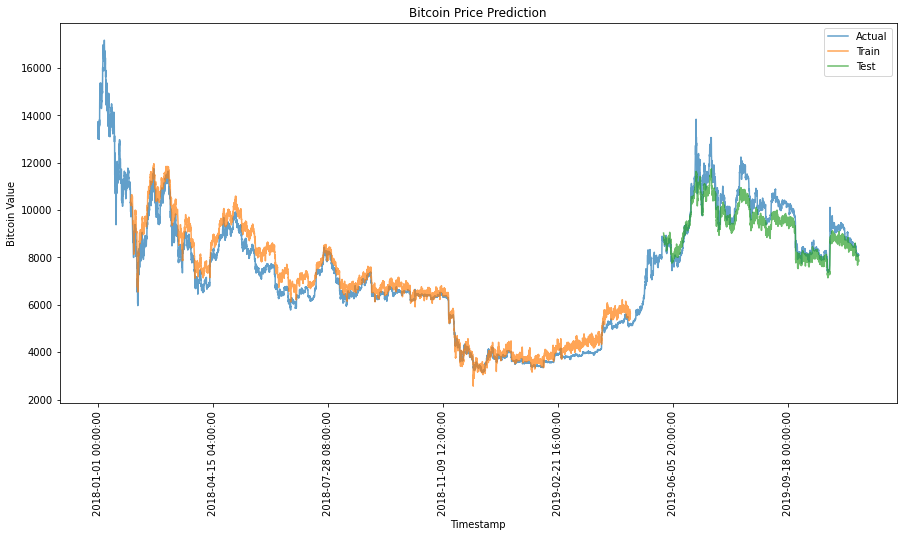

In [86]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredict)+lookBack, predictCol] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(dataset)-1, predictCol] = testPredict

time_df = pd.DataFrame(df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,predictCol]
df1 = pd.DataFrame(trainPredictPlot[:,predictCol],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,predictCol],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')

In [87]:
print('*' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))
print('*' * 50)

**************************************************
Train Score: 491.42 RMSE
Test Score: 572.16 RMSE
**************************************************
